In [1]:
pip install opencv-python-headless matplotlib


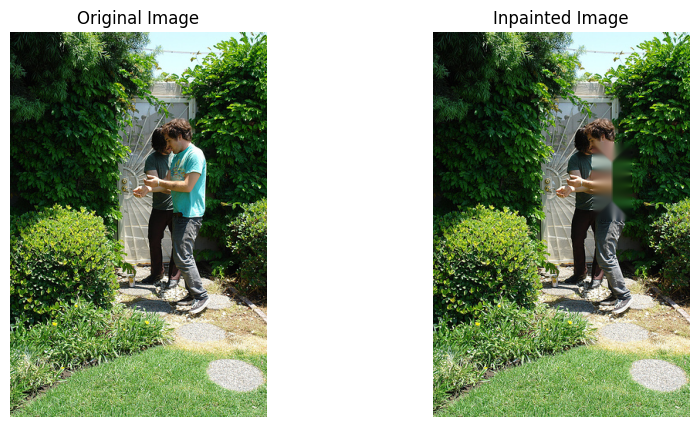

In [11]:
"""This is code to remove objects from images"""
import cv2
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import os

# Load the image
image_path = '/content/drive/MyDrive/Colab Notebooks/MAIproject/Flickr30k-Testset1/1000092795.jpg'
image = cv2.imread(image_path)

# Parse the XML file
xml_path = '/content/drive/MyDrive/Colab Notebooks/MAIproject/Flickr30k-Testset1/1000092795.xml'
tree = ET.parse(xml_path)
root = tree.getroot()

bounding_boxes = []
for obj in root.findall('object'):
    name = obj.find('name').text if obj.find('name') is not None else ''
    bndbox = obj.find('bndbox')
    if bndbox is not None:
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bounding_boxes.append((xmin, ymin, xmax, ymax, name))

# I use inpainting to remove an object from the image
def inpaint_image(image, bounding_boxes):
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    for (xmin, ymin, xmax, ymax,name) in bounding_boxes:
        mask[ymin:ymax, xmin:xmax] = 255

    inpainted_image = cv2.inpaint(image, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
    return inpainted_image

# Select a bounding box to remove by choosing the number of the bounding box from the ground truth
bounding_boxes_to_remove = [bounding_boxes[4]]

# REmove object
inpainted_image = inpaint_image(image, bounding_boxes_to_remove)


# Visualizing the original and inpainted images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Inpainted Image')
plt.imshow(cv2.cvtColor(inpainted_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()


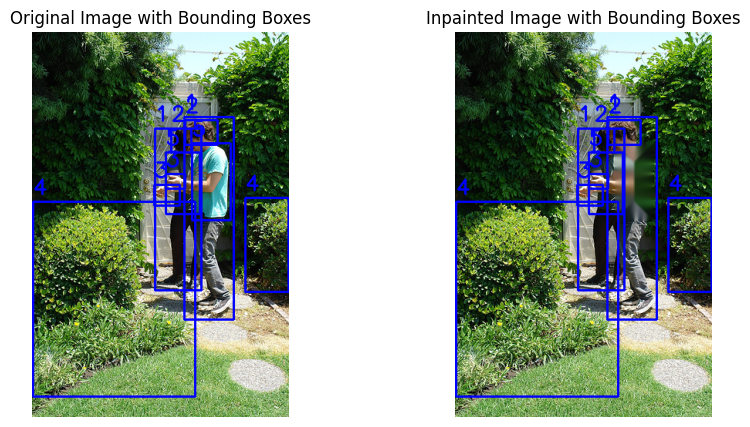

In [15]:
# Visualize the original and inpainted images with bounding boxes -> still ground truth
def draw_bounding_boxes(image, bounding_boxes, color=(255, 0, 0)):
    for (xmin, ymin, xmax, ymax, name) in bounding_boxes:
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 2)
        cv2.putText(image, name, (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
    return image

original_with_boxes = draw_bounding_boxes(image.copy(), bounding_boxes)
inpainted_with_boxes = draw_bounding_boxes(inpainted_image.copy(), [box for box in bounding_boxes if box not in bounding_boxes_to_remove])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image with Bounding Boxes')
plt.imshow(cv2.cvtColor(original_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Inpainted Image with Bounding Boxes')
plt.imshow(cv2.cvtColor(inpainted_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()



In [12]:
# Here i safe the inpainted image
image_basename = os.path.splitext(image_path)[0]

output_image_path = f'{image_basename}_removed_body.jpg'
cv2.imwrite(output_image_path, inpainted_image)




In [ ]:
"""Thats the code if i wanted to change the annotations"""

# Update the XML file by removing the corresponding annotation
objects_to_remove = [bounding_boxes[0]]

def remove_object_annotations(root, objects_to_remove):
    for obj in root.findall('object'):
        bndbox = obj.find('bndbox')
        if bndbox is not None:
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            if (xmin, ymin, xmax, ymax) in objects_to_remove:
                root.remove(obj)

# Remove the specified object annotations
remove_object_annotations(root, bounding_boxes_to_remove)

# Save the updated XML file
output_xml_path = f'{image_basename}_removed_body.xml'
tree.write(output_xml_path)